# JC3503 Assignment - Apartments

---

Student Name: 

Student Email: 

Student ID: 

---

Additional information about the dataset: https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified


### 1. Introduction

In this project I analyzed a dataset of apartments.  These tasks include data cleaning and preprocessing, checking data validity through visualization, incorporating map analysis to visualize apartment rental data across different U.S. states, classifying apartments using K-Means algorithm, and proposing business strategies based on data characteristics.  Finally, I evaluated various prediction models and selected the best one for price prediction.  In this report, I will describe the operations performed, analyze the results, and give my own opinions and takeaways.

### 2. Data Preprocessing

Data preprocessing is essential to prepare the dataset for analysis by cleaning, transforming, and organizing the data.

In this project, the data preprocessing is divided into four main steps:

#### 2.1 Data Loading and Initial Cleaning

This step involves loading the data, examining its structure, and removing duplicate rows to ensure data integrity.

Through studying the dataset, I found the following issues: 1) two types of delimiters, and 2) duplicate rows. This code aims to load and clean the dataset by addressing these issues.

1. **Reading the CSV File**:
   - The `custom_csv_reader` function reads the CSV file and counts lines with commas and semicolons as delimiters.

2. **Loading Data into a DataFrame**:
   - The data is converted into a pandas DataFrame.

3. **Filtering and Cleaning the Data**:
   - The DataFrame is filtered to include only rows where the 'time' column has a length of 10 characters.
   - Duplicate rows are removed based on the 'id' column.

4. **Calculating and Printing Statistics**:
   - Various statistics are calculated and printed to summarize the data cleaning process.

The initial data cleaning process successfully addressed the issues with delimiters and duplicate rows, resulting in a clean dataset with 99,902 unique rows out of the 100,000 lines read, where 99,492 lines used commas, 508 lines used semicolons, and 14 invalid lines were removed.

In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import csv 

# Function to read a CSV file and count the number of lines with commas and semicolons as delimiters
def custom_csv_reader(file_path):
    rows = []
    comma_lines = 0
    semicolon_lines = 0

    # Open the file and read line by line
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            delimiter_char = ','  # Default delimiter is a comma
            if line[10]==';':     # Check if the delimiter is a semicolon
                delimiter_char = ';'
                semicolon_lines += 1
            else:
                comma_lines += 1

            # Read the line using the determined delimiter
            reader = csv.reader([line], delimiter=delimiter_char)
            for row in reader:
                if row[0]=='':
                    print(row)
                rows.append(row)
    return rows, comma_lines-1, semicolon_lines   # Return the rows and the number of lines with commas and semicolons

# Path to the CSV file
file_path = 'apartments.csv'
data, comma_lines, semicolon_lines = custom_csv_reader(file_path)
print(f'Lines with commas: {comma_lines}')
print(f'Lines with semicolons: {semicolon_lines}')

# Convert the data to a DataFrame
df = pd.DataFrame(data[1:], columns=data[0])  # 第一行为列名

# Calculate the total number of lines
total_lines = comma_lines+semicolon_lines

# Filter the DataFrame to include only rows where the 'time' column has a length of 10
df = df[df['time'].str.len()==10]
df.describe()

# Calculate the number of valid lines
normal_lines = len(df)
invalid_lines = total_lines - normal_lines

# Remove duplicate rows based on the 'id' column
df_unique = df.drop_duplicates(subset='id', keep='first')

# Calculate the number of unique lines
unique_lines = len(df_unique)

# Calculate the number of duplicate rows removed
num_duplicates = normal_lines - unique_lines

# Print the statistics
print(f"Total lines read: {total_lines}")
print(f"Lines with commas: {comma_lines}")
print(f"Lines with semicolons: {semicolon_lines}")
print(f"Invalid lines: {invalid_lines}")
print(f"Lines after filtering by time length: {normal_lines}")
print(f"Number of duplicate rows removed: {normal_lines - unique_lines}")
print(f"Lines after removing duplicates: {unique_lines}")

Lines with commas: 99492
Lines with semicolons: 508
Total lines read: 100000
Lines with commas: 99492
Lines with semicolons: 508
Invalid lines: 14
Lines after filtering by time length: 99986
Number of duplicate rows removed: 84
Lines after removing duplicates: 99902


#### 2.2 Data Column Transformation

The purpose of data column transformation is to prepare the dataset for analysis by converting text fields into more structured and analyzable formats. This project transformed three key columns to achieve this:

1. **Pets_Allowed**:
  The Pets_Allowed column is an unstructured text field describing the pet policy of each apartment. To make this data more analyzable, it is split into two boolean columns: Cats_Allowed and Dogs_Allowed, indicating whether cats or dogs are allowed.

2. **Amenities**:
  The Amenities column, also a text field, is simplified into a binary column indicating whether any amenities are mentioned, making it easier to analyze the presence of amenities.

3. **Has_Photo**:
  The Has_Photo column originally contained text indicating whether an apartment listing has a photo. It is converted into a binary format, with 1 indicating the presence of a photo and 0 indicating its absence.

4. **Source**:
  During data transformation, it was found that the Source column had many values, but the vast majority of records had the source as RentDigs.com. Therefore, the Source column was simplified to have a value of 1 if the source is RentDigs.com and 0 otherwise.

These transformations ensure the data is structured and ready for further analysis.

In [2]:
# Display value counts of 'pets_allowed' column
pet_data = df_unique['pets_allowed'].value_counts().reset_index()
print(pet_data)

# Define a function to transform the 'pets_allowed' column into two boolean columns
def parse_pets_allowed(pets):
    if pd.isna(pets) or pets in ['None', 'null']:
        return {'cats_allowed': False, 'dogs_allowed': False}
    return {
        'cats_allowed': 'Cats' in pets,
        'dogs_allowed': 'Dogs' in pets
    }

# Create a new DataFrame 'df_clear' and apply the transformation
df_clear = df_unique.copy()
parsed_pets = df_clear['pets_allowed'].apply(parse_pets_allowed).apply(pd.Series)
df_clear = pd.concat([df_clear, parsed_pets], axis=1)

# Drop the original 'pets_allowed' column
df_clear.drop(columns=['pets_allowed'], inplace=True)

# Count the number of records for each category in 'cats_allowed' and 'dogs_allowed'
cats_count = df_clear['cats_allowed'].value_counts()
dogs_count = df_clear['dogs_allowed'].value_counts()
cats_allowed = len(df_clear[(df_clear['cats_allowed'] == True)])
dogs_allowed = len(df_clear[(df_clear['dogs_allowed'] == True)])
# only_cats_allowed = len(df_clear[df['cats_allowed']==True])
both_allowed = len(df_clear[(df_clear['cats_allowed'] == True) & (df_clear['dogs_allowed'] == True)])
neither_allowed = len(df_clear[(df_clear['cats_allowed'] == False) & (df_clear['dogs_allowed'] == False)])

print("\nCats allowed:")
print(cats_count)
print("\nDogs allowed:")
print(dogs_count)
print(f'cat_allowed :{cats_allowed}')
print(f'dogs_allowed :{dogs_allowed}')
print(f'both_allowed :{both_allowed}')
print(f'neithger_allowed :{neither_allowed}')

# Transform 'amenities' column to 1 if not null and not empty, otherwise 0
df_clear['amenities'] = df_clear['amenities'].apply(lambda x: 1 if pd.notnull(x) and x != '' else 0)
df_clear['has_photo'] = df_clear['has_photo'].apply(lambda x: 0 if pd.notnull(x) and x == 'No' else 1)

# Count the number of records with and without amenities
has_amenities = len(df_clear[df_clear['amenities']==1])
not_has_amenities = len(df_clear[df_clear['amenities']==0])
print(df_clear['amenities'].unique())
print(f'has amenities :{has_amenities} not has amenities :{not_has_amenities}')

# Count the number of records with and without photos
has_photo = len(df_clear[df_clear['has_photo']==1])
not_has_photo = len(df_clear[df_clear['has_photo']==0])
print(f'has photo :{has_photo} not has photo :{not_has_photo}')

# Transform 'source' column to 1 if 'RentDigs.com', otherwise 0
df_clear['source'] = df_clear['source'].apply(lambda x: 1 if x=='RentDigs.com' else 0)
RentDigs_count = len(df_clear[df_clear['source']==1]) 
OtherSource_count = len(df_clear[df_clear['source']==0])
print(f'From RentDigs.com :{RentDigs_count} Other Source :{OtherSource_count}')



     pets_allowed  count
0                  60367
1       Cats,Dogs  37247
2            Cats   1846
3            null    304
4            Dogs    127
5            None     10
6  Cats,Dogs,None      1

Cats allowed:
cats_allowed
False    60808
True     39094
Name: count, dtype: int64

Dogs allowed:
dogs_allowed
False    62527
True     37375
Name: count, dtype: int64
cat_allowed :39094
dogs_allowed :37375
both_allowed :37248
neithger_allowed :60681
[0 1]
has amenities :83869 not has amenities :16033
has photo :90651 not has photo :9251
From RentDigs.com :91321 Other Source :8581


#### 2.3 Data Type Assignment

Data type assignment ensures that each column has the correct data type for accurate analysis. This process includes:

- Numeric Columns: Columns such as bathrooms, bedrooms, square_feet, price, latitude, and longitude are converted to numeric types. Errors in conversion are coerced to NaN, and missing values are filled with 0.

- Categorical Columns: Columns such as amenities, currency, fee, has_photo, price_type, state, and source are converted to categorical data types for better handling in analysis.

By assigning appropriate data types, the dataset becomes structured and ready for further processing and analysis.

In [3]:
# Define the numeric and categorical columns
numeric_columns = ['bathrooms','bedrooms','square_feet','price','latitude','longitude']
category_columns = ['amenities', 'bathrooms', 'bedrooms',
       'currency', 'fee', 'has_photo',  'price_type',
        'state',
       'source']

# Convert numeric columns to numeric data types, coercing errors to NaN
for column in numeric_columns:
    df_clear[column] = pd.to_numeric(df_clear[column], errors='coerce')

# Handle missing values in numeric columns by filling them with 0
for column in numeric_columns:
    missing_data = df_clear[df_clear[column].isnull()]
    print(f'There are {len(missing_data)} records that is null value in {column} column')
    df_clear[column] = df_clear[column].fillna(0)

# Convert categorical columns to 'category' data type
for column in category_columns:
    df_clear[column] = df_clear[column].astype('category')



There are 63 records that is null value in bathrooms column
There are 124 records that is null value in bedrooms column
There are 0 records that is null value in square_feet column
There are 1 records that is null value in price column
There are 25 records that is null value in latitude column
There are 25 records that is null value in longitude column


#### 2.4 Data Visualization and Validation

The dataset is large, so visualizing the value distribution for each column helps to quickly identify outliers and assess the results of data cleaning. This step involves:

1. **Selecting Columns**: Choose columns that are not of type 'object' for visualization. In previous steps, columns useful for data analysis were converted to the correct data types, while some columns like 'Address' and 'Title', containing unstructured text information, were not converted and remain as 'object' type.

2. **Plotting Distributions**: 
   - For numeric columns (excluding 'has_photo' and 'amenities'), histograms with Kernel Density Estimate (KDE) are plotted to show the value distribution.
   - For non-numeric columns, count plots are created to show the frequency of each unique value.

3. **Setting Up the Plot**: 
   - Determine the number of subplots based on the number of columns.
   - Plot each column in its respective subplot.

4. **Finalizing the Plot**: 
   - If the number of columns is odd, remove the last empty subplot.
   - Adjust the layout for better readability.

By visualizing the data, this step helps in identifying any outliers, missing values, or unusual patterns, ensuring that the data is ready for further analysis.

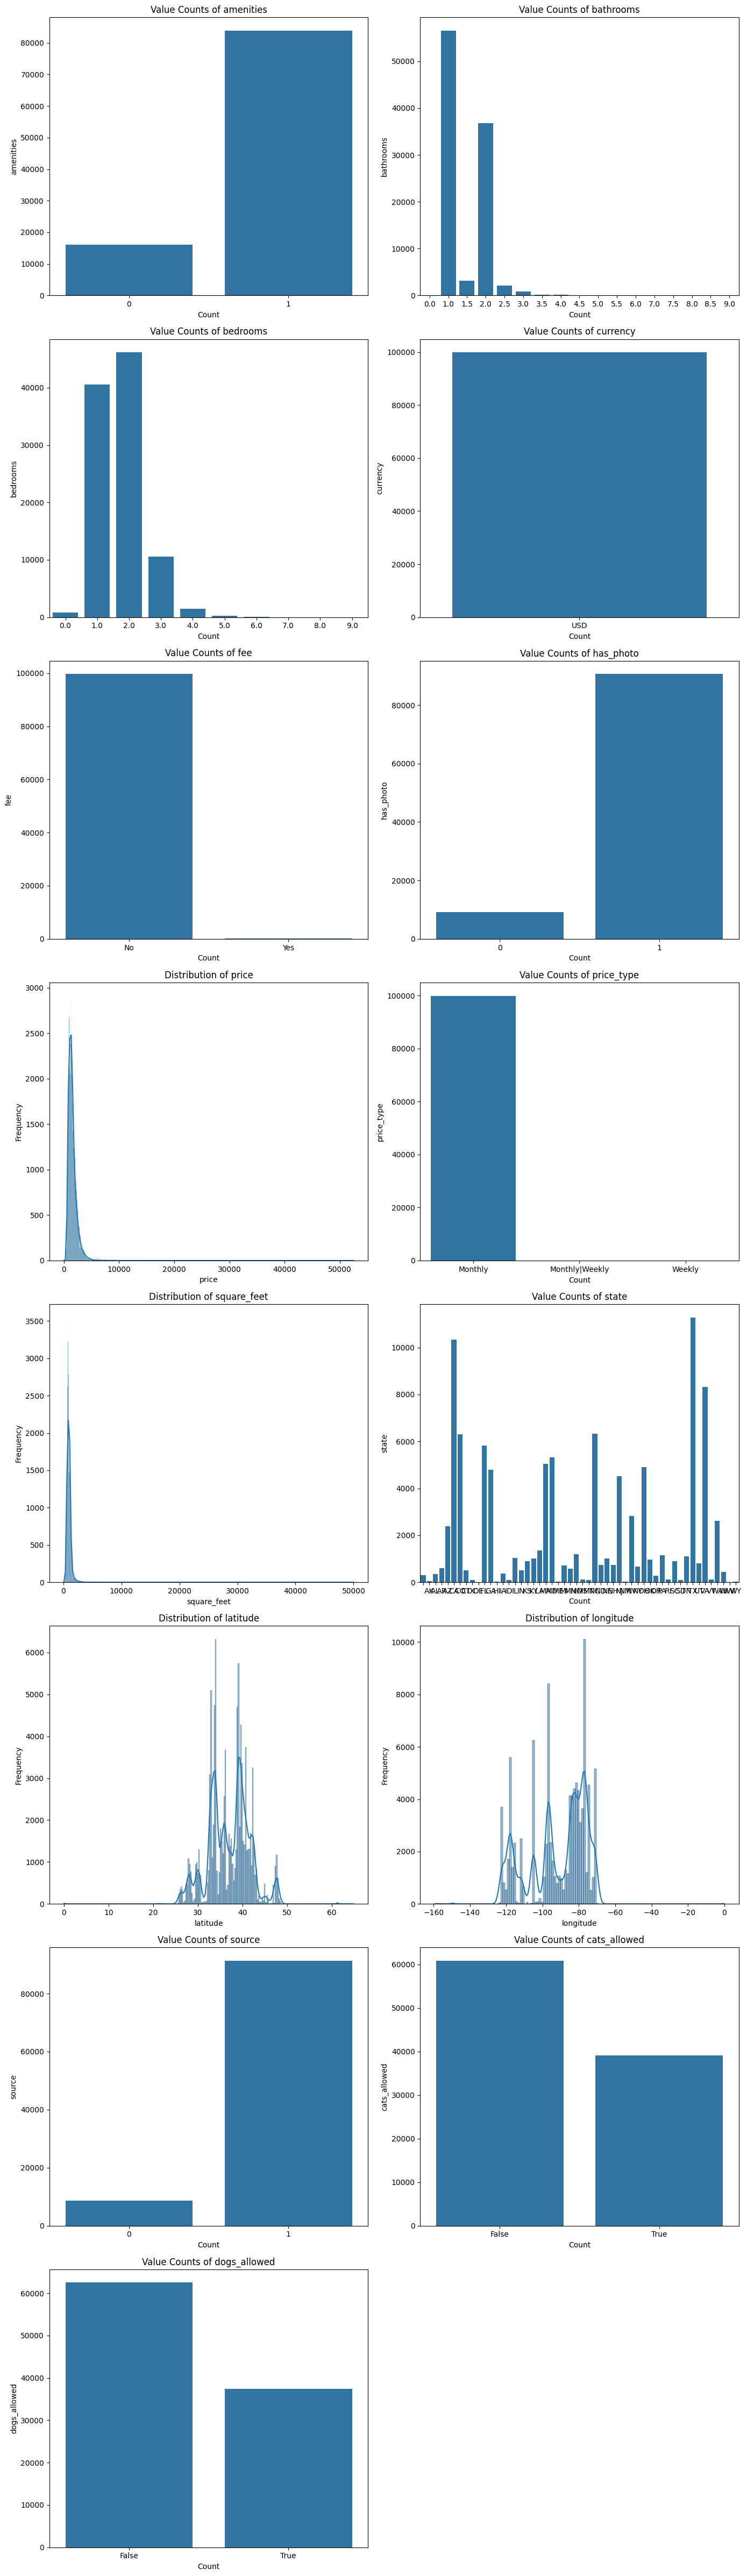

In [195]:
# Select columns that are not of type 'object'
columns =  df_clear.select_dtypes(exclude=['object']).columns

# Function to plot the distribution of a column
def plot_column_distribution(ax, df, column):
    # Plot histograms for numeric columns (excluding 'has_photo' and 'amenities')
    if df[column].dtype in ['int64', 'float64'] and column!='has_photo' and column!='amenities':
        sns.histplot(df[column], kde=True, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
    else:
        # Plot count plots for non-numeric columns
        sns.countplot(x=df[column], ax=ax)
        ax.set_title(f'Value Counts of {column}')
        ax.set_xlabel('Count')
        ax.set_ylabel(column)

# Set the size and layout of the plot
n_cols = 2
n_rows = -(-len(columns) // n_cols)  # 向上取整
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 6))

# Plot the distribution for each column
for i, col in enumerate(columns):
    row = i // n_cols
    col_pos = i % n_cols
    plot_column_distribution(axes[row, col_pos], df_clear, col)

# If the number of columns is odd, remove the last empty subplot
if len(columns) % n_cols != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


##### 2.4.1 Understanding Data Through Visualization

From the charts, we can see that most columns have expected distributions, while the 'price' and 'square_feet' columns have a wide range of values with most data concentrated in a narrow range, indicating the need for further analysis. The 'fee' and 'price_type' columns each have one very high bar with others almost nonexistent, requiring further investigation. Additionally, the 'currency' column contains only 'USD,' making it irrelevant for data analysis.

##### 2.4.2 Outlier Identification and Analysis

To examine the price and square_feet columns, box plots are created to identify potential outliers. For the fee and price_type columns, the count of unique values is checked to understand their distribution.

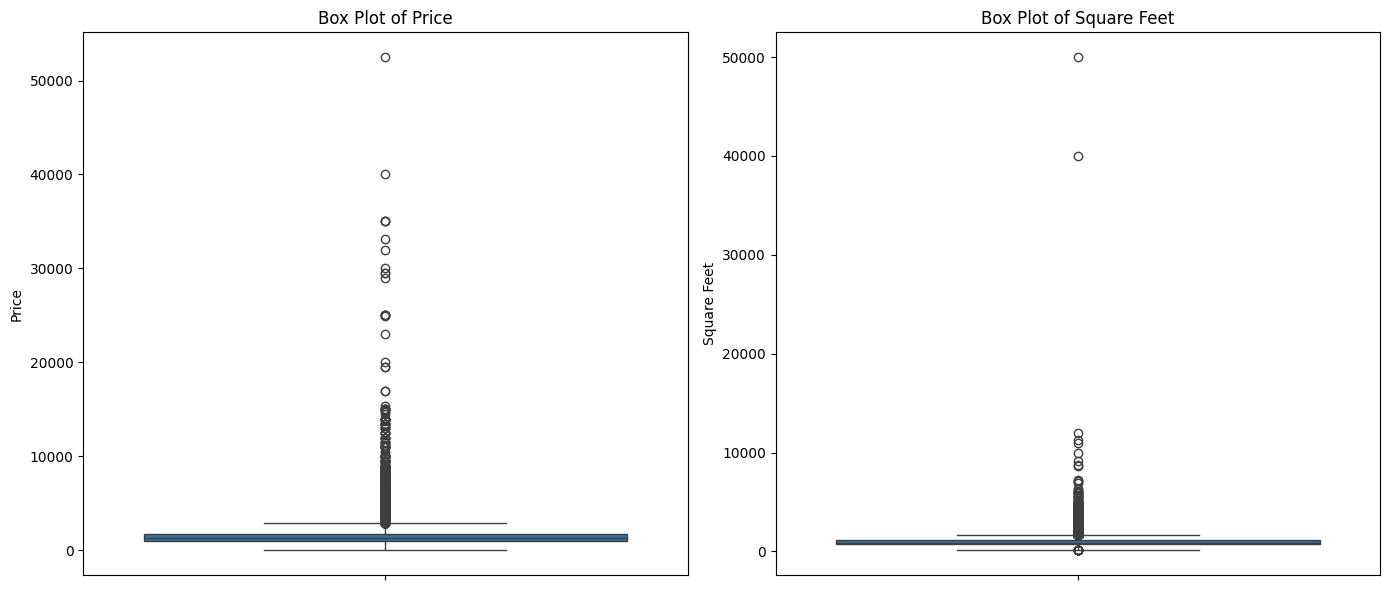

Number of outliers in price: 4708
Number of outliers in square_feet: 2857
price_type
Monthly           99898
Weekly                3
Monthly|Weekly        1
Name: count, dtype: int64
fee
No     99701
Yes      201
Name: count, dtype: int64


In [4]:

# Define a function to count the number of outliers in a series
def count_outliers(series):
    q1 = series.quantile(0.25)   # Calculate the first quartile
    q3 = series.quantile(0.75)   # Calculate the third quartile
    iqr = q3 - q1                # Calculate the interquartile range (IQR)
    lower_bound = q1 - 1.5 * iqr    # Calculate the lower bound for outliers
    upper_bound = q3 + 1.5 * iqr    # Calculate the upper bound for outliers
    outliers = series[(series < lower_bound) | (series > upper_bound)]   # Identify outliers
    return outliers.count()      # Return the number of outliers

# Create box plots for the 'price' and 'square_feet' columns to visualize outliers
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Box plot for 'price'
sns.boxplot(y=df_clear['price'], ax=axes[0])
axes[0].set_title('Box Plot of Price')
axes[0].set_ylabel('Price')

# Box plot for 'square_feet
sns.boxplot(y=df_clear['square_feet'], ax=axes[1])
axes[1].set_title('Box Plot of Square Feet')
axes[1].set_ylabel('Square Feet')

plt.tight_layout()
plt.show()

# Calculate the number of outliers in the 'price' and 'square_feet' columns
price_outliers = count_outliers(df_clear['price'])
square_feet_outliers = count_outliers(df_clear['square_feet'])

# Print the number of outliers in each column
print(f'Number of outliers in price: {price_outliers}')
print(f'Number of outliers in square_feet: {square_feet_outliers}')

# Print the value counts for 'price_type' and 'fee' columns
print(df_clear['price_type'].value_counts())
print(df_clear['fee'].value_counts())


##### 2.4.3 Outlier Analysis

Through box plots and the IQR method, the outlier counts for `price` and `square_feet` were determined. The box plots show that there are 4708 outliers for `price` and 2857 outliers for `square_feet`, which are acceptable and will not be removed from the dataset. Additionally, `price_type` has only 4 records that are not 'monthly', and `fee` has only 201 records that indicate a fee is required. Given these low counts, these fields will not be modified further, and the analysis will proceed without adjusting these values.

### 3. Geographic Data Analysis

The dataset includes apartment data from across the United States. Using maps allows us to easily visualize the number and average price of apartments in different regions. GeoPandas is used for geographic data handling, and requests is used to download map data from the internet. First, run the following pip commands to install the necessary packages:


In [73]:
!pip install geopandas
!pip install requests


Since Alaska and Hawaii are far from the mainland, their maps are excluded to better display the data. The code provided downloads the state boundary data, processes the apartment data, and creates visualizations showing the number and average price of apartments in each state on a map.

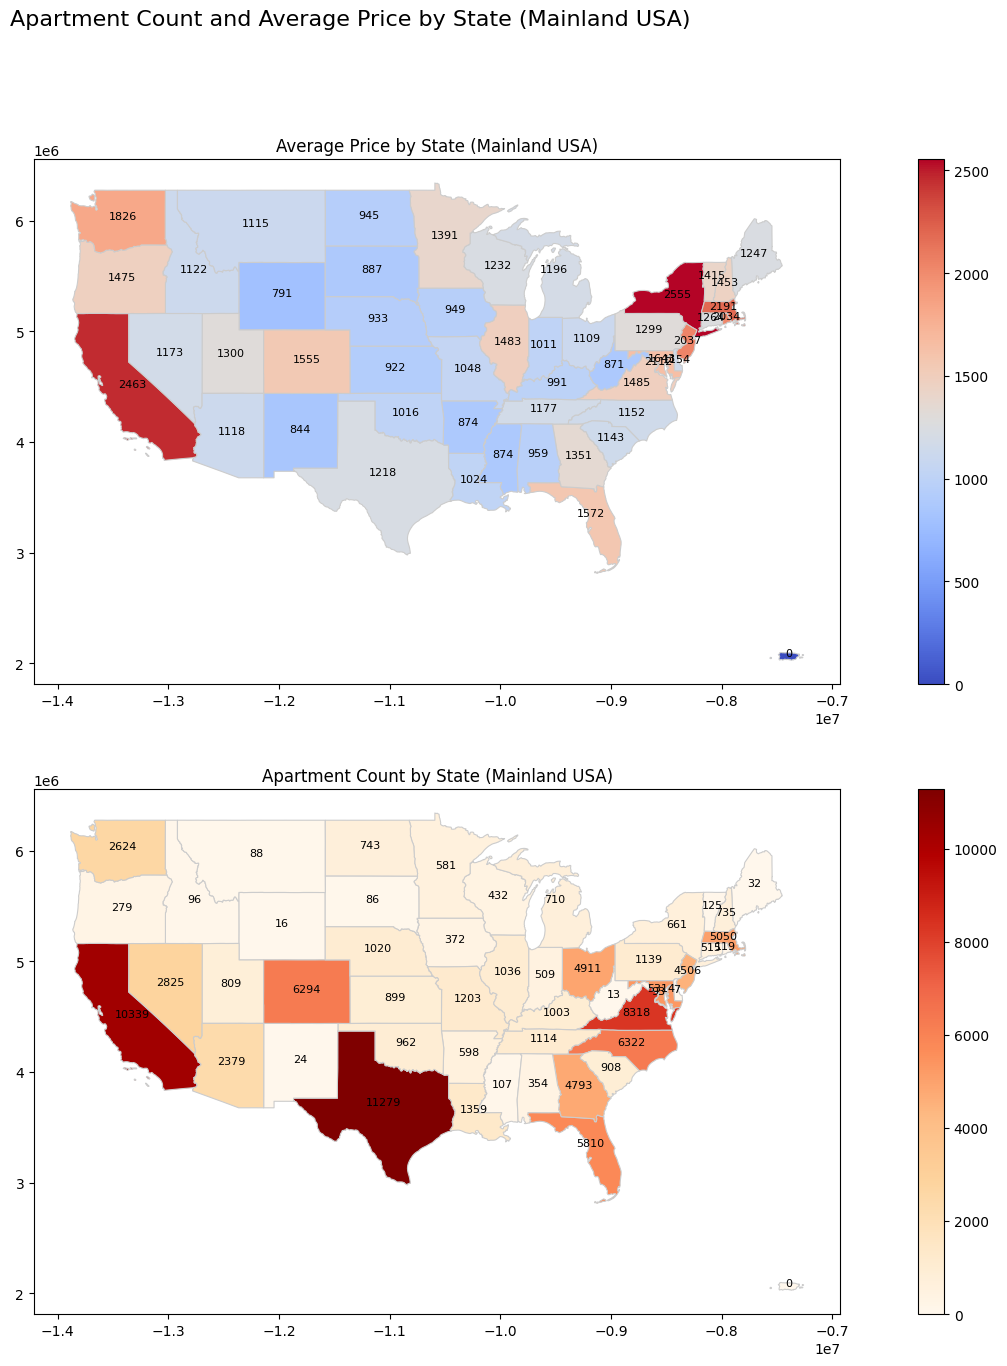

In [5]:
import geopandas as gpd
from io import BytesIO
from zipfile import ZipFile
import requests

# Download and load state boundary data
url = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip'
response = requests.get(url)
with ZipFile(BytesIO(response.content)) as z:
    z.extractall('usa_states')
states = gpd.read_file('usa_states/cb_2021_us_state_20m.shp')

# Filter out Alaska (AK) and Hawaii (HI)
states = states[~states['STUSPS'].isin(['AK', 'HI'])]

# Calculate the number of houses and average price for each state
state_data = df_clear.groupby('state', observed=False).agg(
    house_count=('price', 'size'),
    avg_price=('price', 'mean')
).reset_index()

# Merge the calculated data with the state boundary data
state_data_gdf = states.merge(state_data, left_on='STUSPS', right_on='state', how='left')

# Fill default values for states without data
state_data_gdf['house_count'] = state_data_gdf['house_count'].fillna(0)
state_data_gdf['avg_price'] = state_data_gdf['avg_price'].fillna(0)

# Convert average price and house count to integers
state_data_gdf['avg_price'] = state_data_gdf['avg_price'].astype(int)
state_data_gdf['house_count'] = state_data_gdf['house_count'].astype(int)

state_data_gdf = state_data_gdf.to_crs(epsg=3857)

# Plot the maps
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

# Plot average price map
state_data_gdf.plot(column='avg_price', cmap='coolwarm', linewidth=0.8, ax=axes[0], edgecolor='0.8', legend=True)
axes[0].set_title('Average Price by State (Mainland USA)')

# Add the average price labels
for x, y, label in zip(state_data_gdf.geometry.centroid.x, state_data_gdf.geometry.centroid.y, state_data_gdf['avg_price']):
    axes[0].text(x, y, label, fontsize=8, ha='center', color='black')

# Plot the apartment count map
state_data_gdf.plot(column='house_count', cmap='OrRd', linewidth=0.8, ax=axes[1], edgecolor='0.8', legend=True)
axes[1].set_title('Apartment Count by State (Mainland USA)')

# Add apartment count labels
for x, y, label in zip(state_data_gdf.geometry.centroid.x, state_data_gdf.geometry.centroid.y, state_data_gdf['house_count']):
    axes[1].text(x, y, label, fontsize=8, ha='center', color='black')

# Set the overall title
fig.suptitle('Apartment Count and Average Price by State (Mainland USA)', fontsize=16)

plt.show()


##### Map Analysis with Economic Insights

These maps provide a visual representation of the average apartment prices and apartment counts by state in mainland USA, highlighting regional disparities and economic factors.

***Average Price by State***

The first map shows the average price of apartments in different states, with red indicating higher prices and blue indicating lower prices. Key observations:

- California (2463), New York (2344), and Massachusetts (2097) have the highest prices due to large urban centers with high demand for housing.
- Central states like Kansas (874), Oklahoma (874), and West Virginia (844) have lower prices, reflecting a lower cost of living and less urbanization.
- Significant regional disparities in prices are influenced by local economies, job opportunities, and population density.

***Apartment Count by State***

The second map displays the number of apartments listed in each state, with darker shades indicating more listings. Key observations:

- Texas (11279), California (10339), and Florida (8318) have the highest counts due to large populations and multiple metropolitan areas.
- States like North Dakota (16), Vermont (24), and Wyoming (32) have very few listings, reflecting smaller populations and fewer urban centers.
- In the Northeast, states like New York and Massachusetts have high prices but not necessarily high apartment counts, driven by limited space and high demand in specific urban areas.

These maps highlight the economic conditions, population density, and urbanization influencing apartment prices and availability across mainland USA.

### 4. Apartment Classification

By using clustering algorithms, nearly 100,000 apartments can be classified into distinct categories. For each category, specific business strategies can be formulated based on their unique characteristics. Determining the optimal number of clusters helps in creating meaningful and manageable segments.

First, I used the KMeans clustering algorithm to determine the optimal number of clusters. Once the optimal number of clusters was established, the apartments were classified accordingly. The characteristics of each cluster were then analyzed to propose effective operational strategies for each category. 

Using clustering in this way allows for better-targeted marketing, pricing strategies, and service enhancements tailored to the needs of each specific group of apartments.

#### 4.1 Determining the Optimal Number of Clusters

To classify the apartments effectively, it is essential to determine the optimal number of clusters. This ensures meaningful segmentation and aids in developing targeted business strategies. The process to determine the optimal number of clusters involves the following steps:

1. **Applying KMeans Clustering**:
   The KMeans clustering algorithm is applied with different values of `k` (number of clusters) ranging from 2 to 9. For each value of `k`, the model is evaluated based on:
   - **Inertia**: The sum of squared distances of samples to their closest cluster center. Lower inertia values indicate tighter clusters and more coherent grouping of the data points.
   - **Silhouette Score**: A measure of how similar an object is to its own cluster compared to other clusters. Higher silhouette scores indicate better-defined and more distinct clusters.
   - **Fit Time**: The time taken to fit the model, ensuring the clustering process is computationally feasible.

2. **Evaluating Results**:
   The inertia and silhouette scores are plotted to identify the optimal number of clusters. Even though the graph suggests k=2 as having the highest Silhouette Score, k=5 seems to be a good compromise as it balances a reasonably high Silhouette Score with a significant reduction in Inertia. This suggests k=5 is a suitable choice for clustering, providing a good balance between cluster compactness and separation.



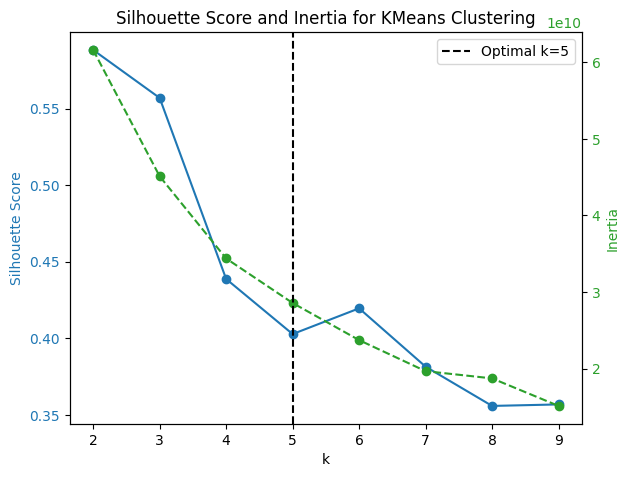

In [205]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import time

# Data Preparation, Change boolean data to integer
df_clear['dogs_allowed'] = df_clear['dogs_allowed'].astype(int)
df_clear['cats_allowed'] = df_clear['cats_allowed'].astype(int)

# Selecting features for clustering
features = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'amenities',  
            'has_photo', 'source', 'cats_allowed', 'dogs_allowed']

X = df_clear[features]

# Lists to store inertia, silhouette scores, and fit times for different k values
inertia = []
silhouette_scores = []
fit_times = []

# Loop through k values from 2 to 9
for k in range(2, 10):
    start_time = time.time()    # Start timer
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)   # Initialize KMeans
    kmeans.fit(X)
    fit_times.append(time.time() - start_time)     # Record fit time
    
    labels = kmeans.labels_       # Get cluster labels
    inertia.append(kmeans.inertia_)     # Record inertia
    silhouette_scores.append(silhouette_score(X, labels))     # Record silhouette score

# Plotting the results
fig, ax1 = plt.subplots()

# Plot silhouette scores
color = 'tab:blue'
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(range(2, 10), silhouette_scores, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# # Plot fit times on a secondary y-axis
# ax2 = ax1.twinx()
# color = 'tab:green'
# ax2.set_ylabel('Fit Time (seconds)', color=color)
# ax2.plot(range(2, 10), fit_times, 'o--', color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# Plot fit times on a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Inertia', color=color)
ax2.plot(range(2, 10), inertia, 'o--', color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()
plt.title('Silhouette Score and Inertia for KMeans Clustering')
plt.axvline(x=5, color='k', linestyle='--', label='Optimal k=5')
plt.legend()
plt.show()


#### 4.2 Clustering and Visualizing Apartment Data

The following code performs clustering to divide the apartment data into five categories. This is done in three main steps:

1. **Clustering**:
   The KMeans algorithm is used to cluster the data into five groups based on features such as bathrooms, bedrooms, price, square footage, amenities, has photo, source, cats allowed, and dogs allowed. 

2. **Dimensionality Reduction for Visualization**:
   Principal Component Analysis (PCA) is applied to reduce the data to two dimensions. This allows us to visualize the clustering results using a scatter plot. Each point represents an apartment, colored by its assigned cluster.

3. **Visualizing Cluster Characteristics**:
   The characteristics of each cluster are displayed in two ways:
   - **Bar Charts**: The center values of each cluster for all features are shown using bar charts.
   - **Box Plots**: The distribution of each feature within each cluster is depicted using box plots, allowing us to see the range and variability of each feature across different clusters.



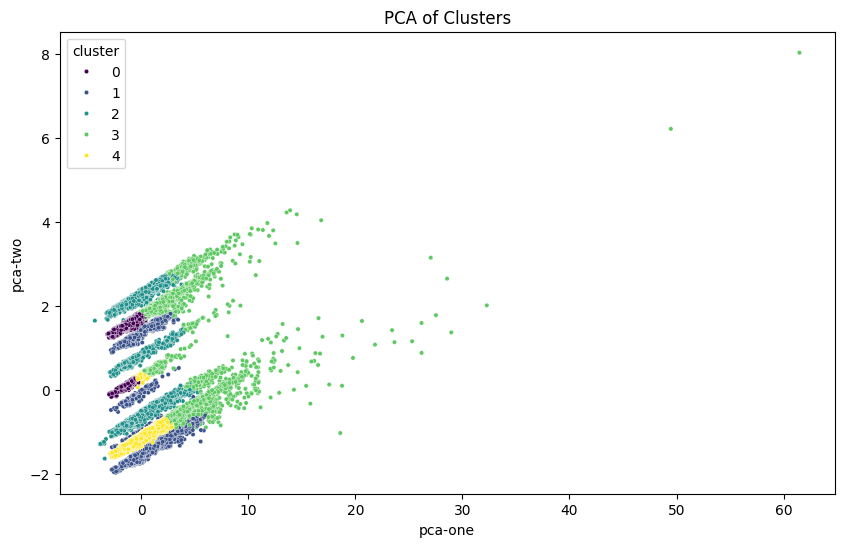

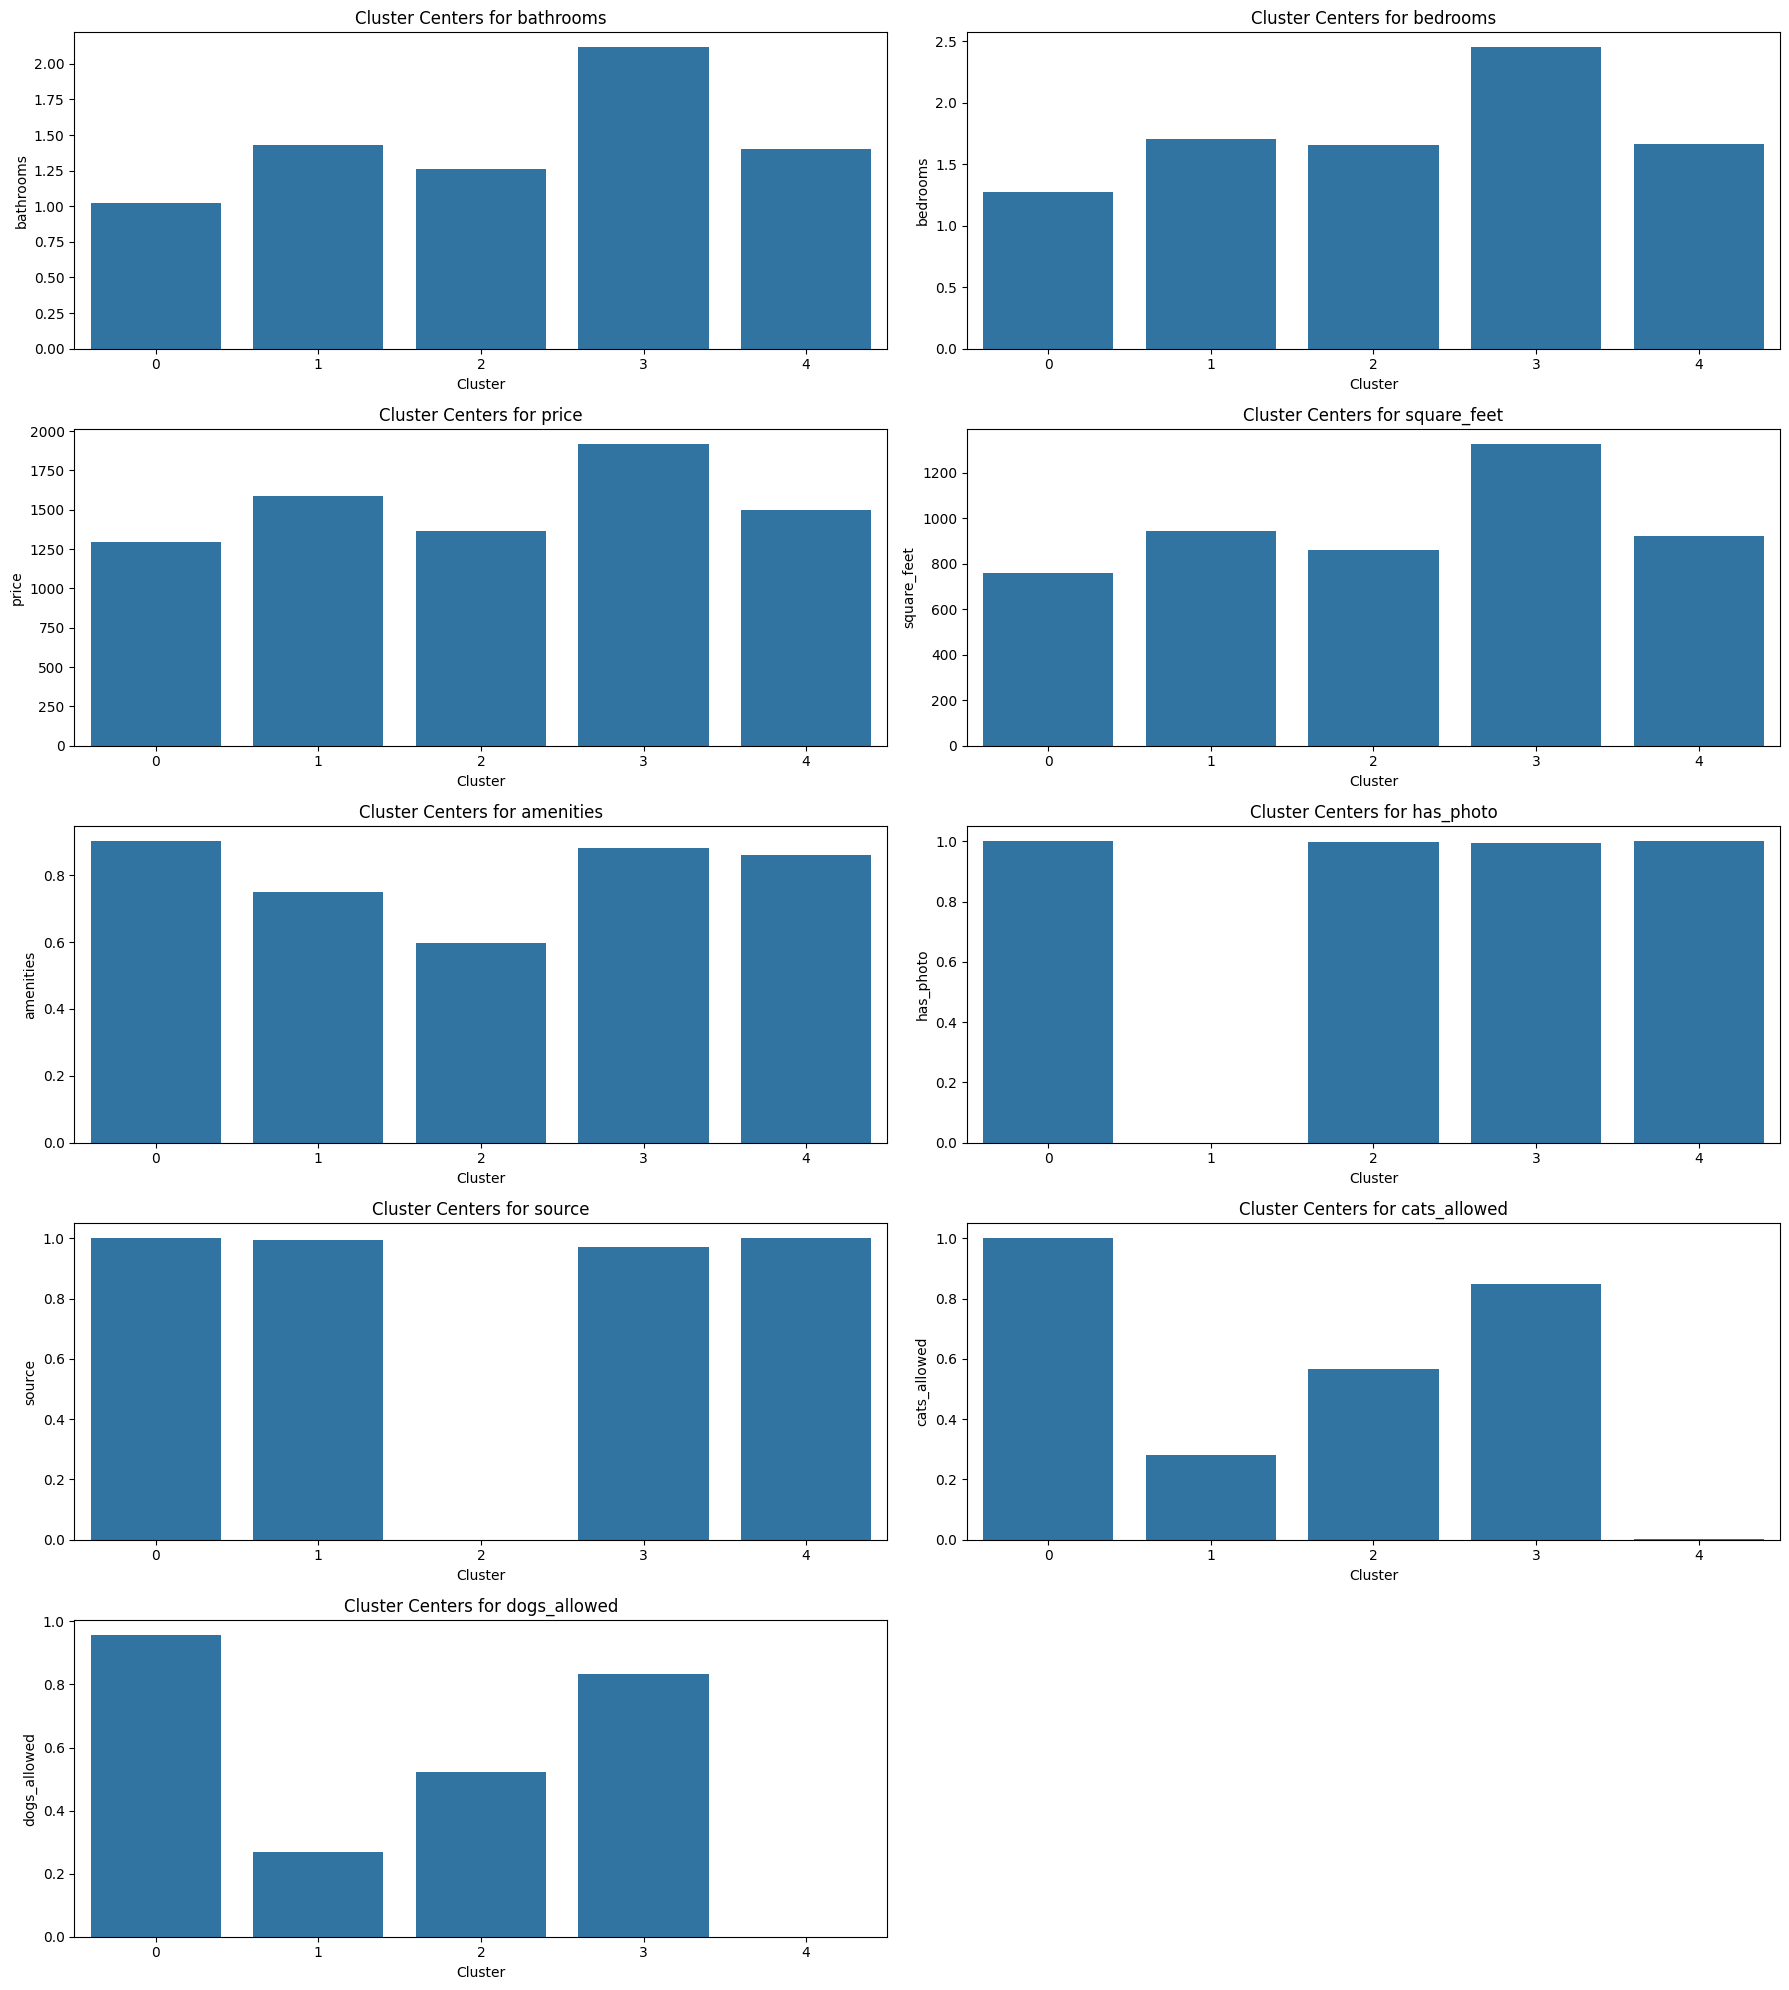

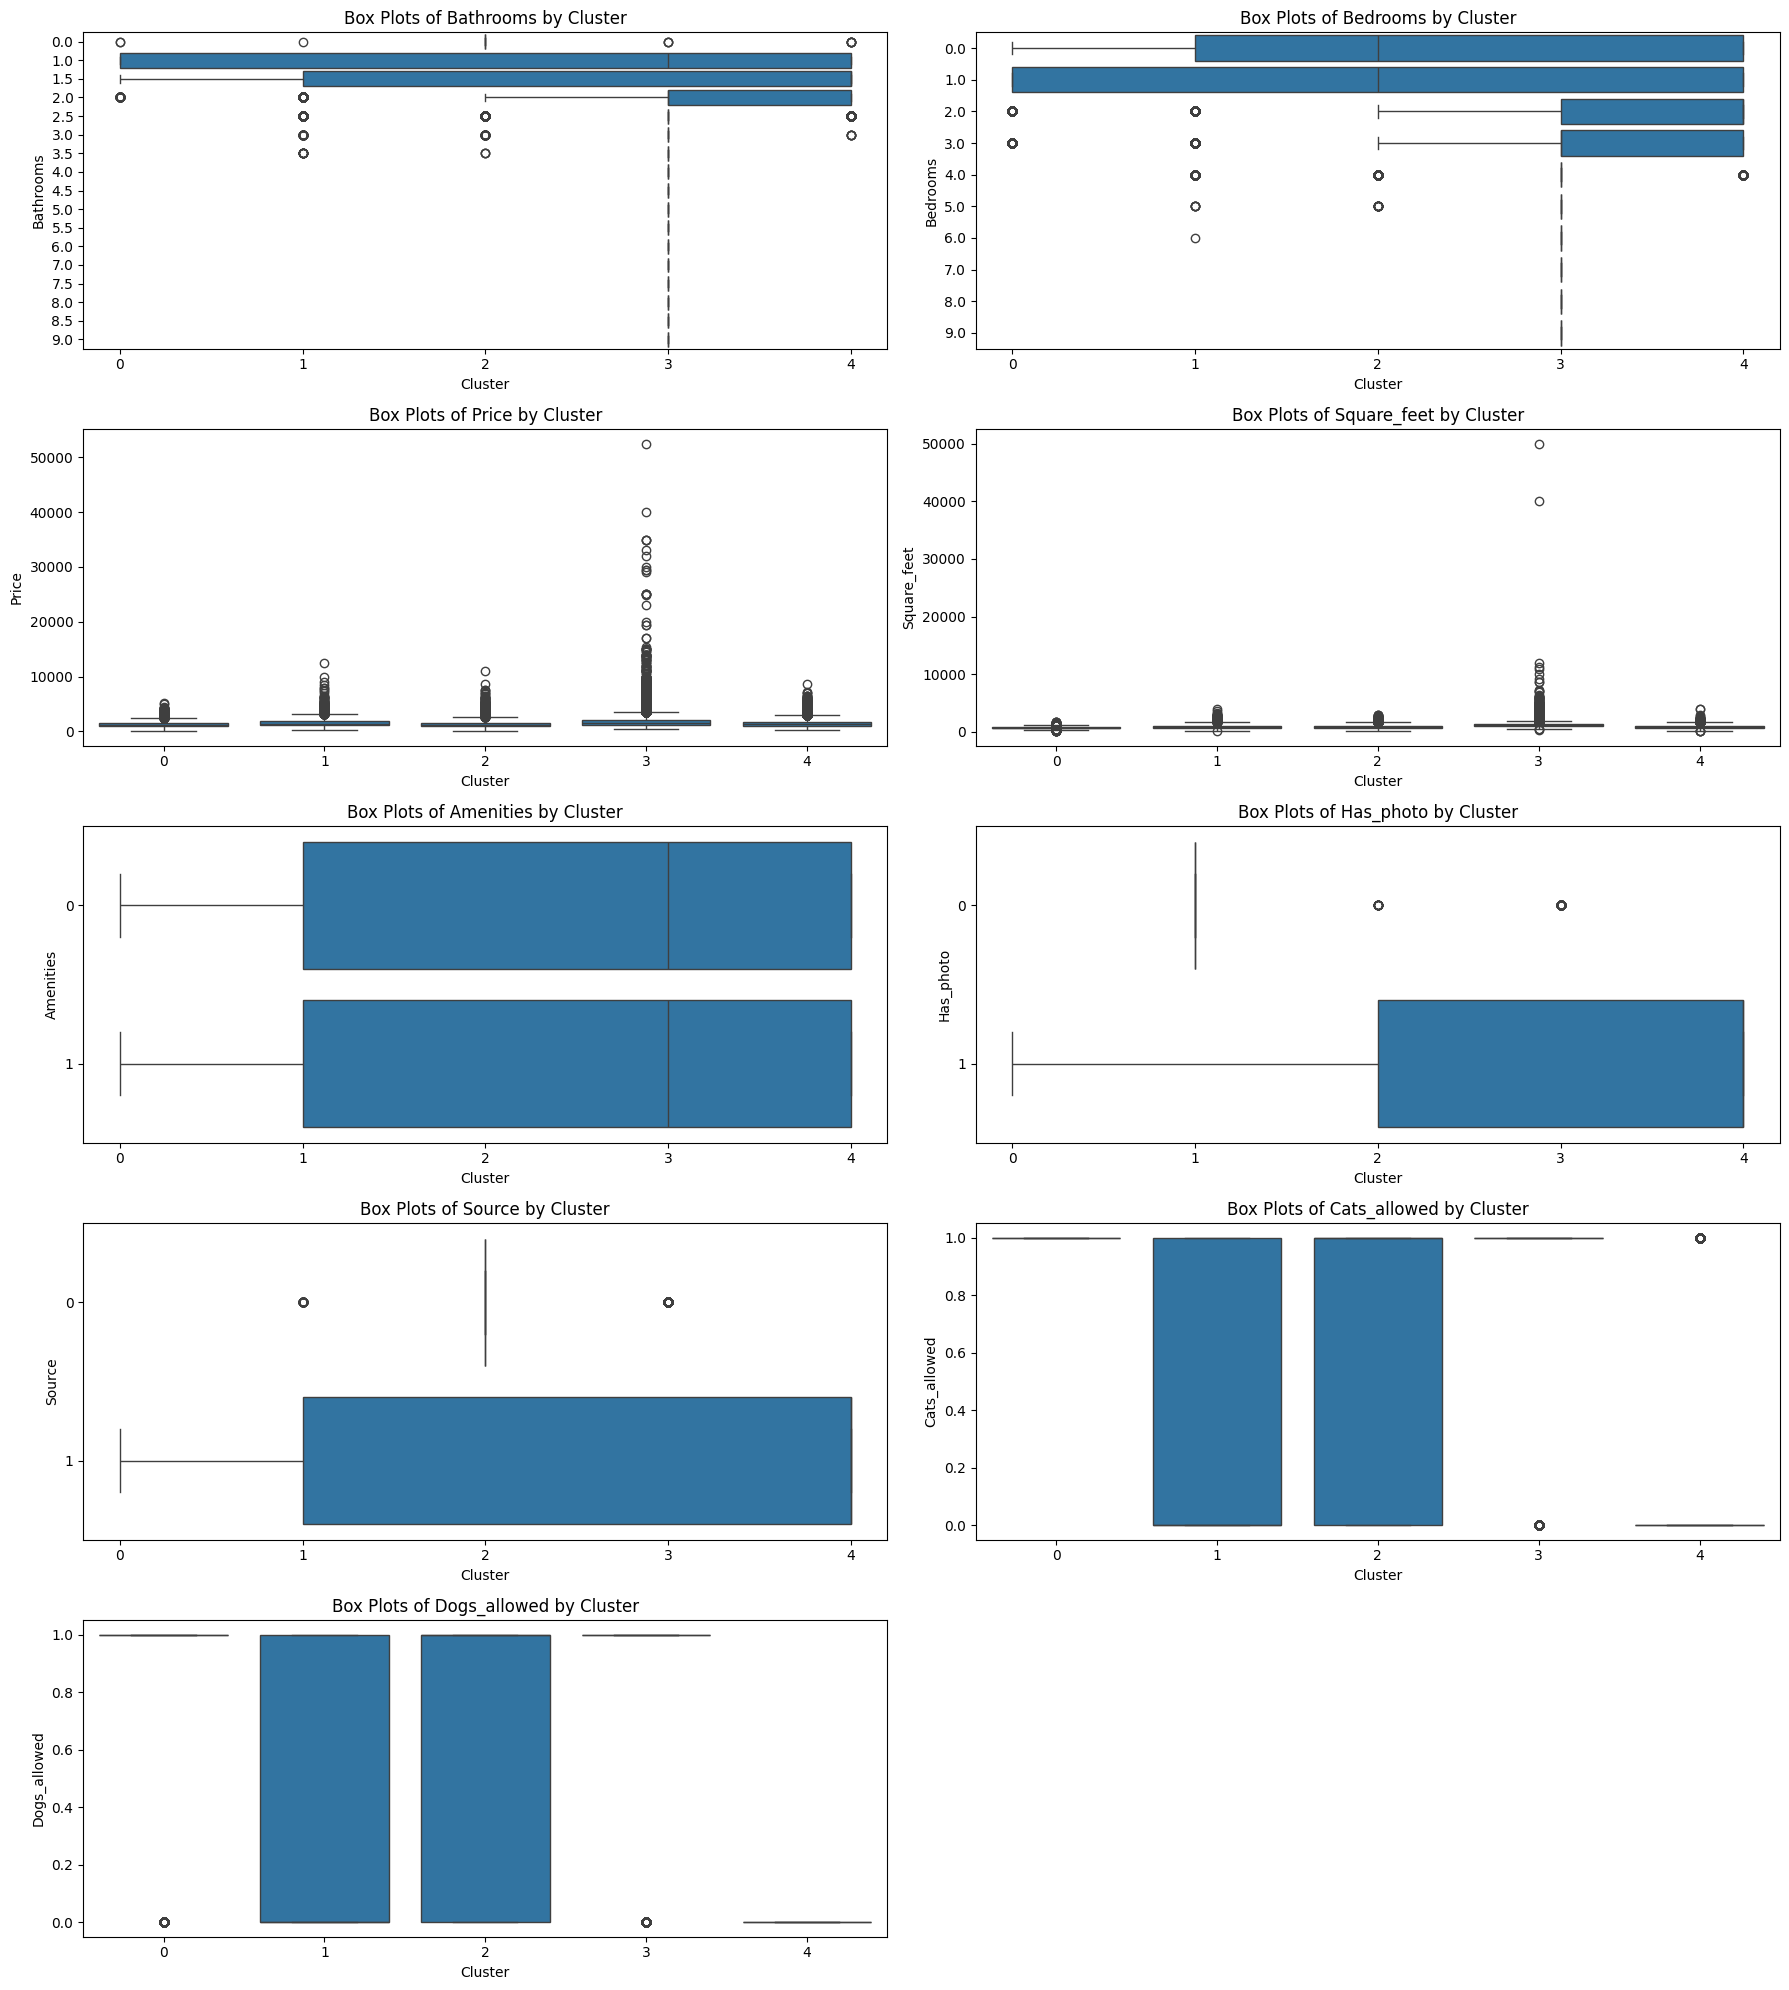

In [201]:
from sklearn.decomposition import PCA

# Define the features to be used in the clustering
features = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'amenities',  
            'has_photo', 'source', 'cats_allowed', 'dogs_allowed']

# Apply KMeans clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
df_clear['cluster'] = kmeans.fit_predict(scaled_features)

# Use PCA for dimensionality reduction for visualization purposes
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
df_clear['pca-one'] = pca_result[:, 0]
df_clear['pca-two'] = pca_result[:, 1]

# Visualize the clustering results using PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clear, x='pca-one', y='pca-two', hue='cluster', palette='viridis', s=10)
plt.title('PCA of Clusters')
plt.show()

# Transform the PCA components back to the original feature space
original_data = pca.inverse_transform(df_clear[['pca-one', 'pca-two']])
original_data_unscaled = scaler.inverse_transform(original_data)

# Print the center points of each cluster
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)

# Plot the feature values of each cluster center using bar charts
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 20))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.barplot(x=cluster_centers_df.index, y=cluster_centers_df[feature], ax=axes[i])
    
    axes[i].set_title(f'Cluster Centers for {feature}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

# Remove the last empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Plot the distribution of each feature within clusters using box plots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 20))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='cluster', y=feature, data=df_clear, ax=axes[i])
    
    axes[i].set_title(f'Box Plots of {feature.capitalize()} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature.capitalize())
    axes[i].set_xticks(range(5))

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


#### 4.3 Cluster Characteristics and Business Strategies

Based on the analysis of the cluster centers, the apartment data can be categorized into five distinct clusters. Here are the characteristics and proposed business strategies for each cluster:

1. **Cluster 0: Basic Apartments**
   - **Characteristics**: 
     - Average of 1 bathroom
     - 1-2 bedrooms
     - Moderate price
     - Average square feet
     - Few amenities
     - Most listings have photos
     - Majority of sources are from RentDigs.com
     - Pets allowed in some cases
   - **Strategy**: 
     - Target budget-conscious renters such as students or young professionals.
     - Emphasize affordability and essential amenities.
     - Highlight the availability of pets in marketing.

2. **Cluster 1: Budget-Friendly Apartments**
   - **Characteristics**: 
     - About 1.5 bathrooms
     - 1-2 bedrooms
     - Moderate price
     - Average square feet
     - Few amenities
     - All listings have photos
     - All sources are from RentDigs.com
     - Pets not allowed
   - **Strategy**: 
     - Market to single renters or couples looking for affordable living.
     - Focus on competitive pricing and basic features.
     - Ensure high-quality photos in listings to attract attention.

3. **Cluster 2: Standard Apartments**
   - **Characteristics**: 
     - About 1 bathroom
     - 1-2 bedrooms
     - Moderate to high price
     - Larger square feet
     - Most amenities available
     - All listings have photos
     - Majority of sources are from RentDigs.com
     - Pets allowed in some cases
   - **Strategy**: 
     - Target families or professionals looking for a comfortable living space.
     - Highlight the spaciousness and available amenities.
     - Use high-quality photos to showcase the features of the apartments.

4. **Cluster 3: Premium Apartments**
   - **Characteristics**: 
     - 2 bathrooms
     - 2-3 bedrooms
     - High price
     - Largest square feet
     - Most amenities available
     - All listings have photos
     - Majority of sources are from RentDigs.com
     - Pets allowed
   - **Strategy**: 
     - Target high-income families and professionals.
     - Emphasize luxury features and spacious living areas.
     - Use high-quality marketing materials to highlight the premium aspects of the apartments.

5. **Cluster 4: Mid-Range Apartments**
   - **Characteristics**: 
     - 1-1.5 bathrooms
     - 1-2 bedrooms
     - Moderate price
     - Average square feet
     - Some amenities available
     - Most listings have photos
     - Majority of sources are from RentDigs.com
     - Pets allowed in some cases
   - **Strategy**: 
     - Target middle-income renters.
     - Focus on a balance of price and amenities.
     - Highlight the availability of pets and use quality photos to attract renters.

### 5. Predicting Apartment Prices

To find the best prediction algorithm, the following models were applied: Linear Regression, Ridge Regression, Lasso Regression, Decision Tree, Random Forest, Gradient Boosting, and Support Vector Regression (SVR).

Despite trying various algorithms and hyperparameters, the prediction results were not very accurate. The best model was found to be Random Forest, but even this model had a high Mean Squared Error (MSE) and a low R-squared value. 

**Best Model:** Random Forest
- **Mean Squared Error:** 578846.7145297064
- **R-squared:** 0.1125547946301848

The reason for the poor performance could be that the dataset is too large and complex for the algorithms to capture all the necessary features effectively. 

Training LinearRegression...
Training Ridge...
Training Lasso...
Training DecisionTree...
Training RandomForest...
Training GradientBoosting...
Training SVR...

Best Models and their MSE scores:
LinearRegression: MSE = 728910.4496014841
Ridge: MSE = 728822.0764424352
Lasso: MSE = 728817.2874101106
DecisionTree: MSE = 702092.1134966465
RandomForest: MSE = 615912.858577763
GradientBoosting: MSE = 638053.6420658298
SVR: MSE = 780412.90909912

Best Model: RandomForest
Mean Squared Error: 578846.7145297064
R-squared: 0.1125547946301848


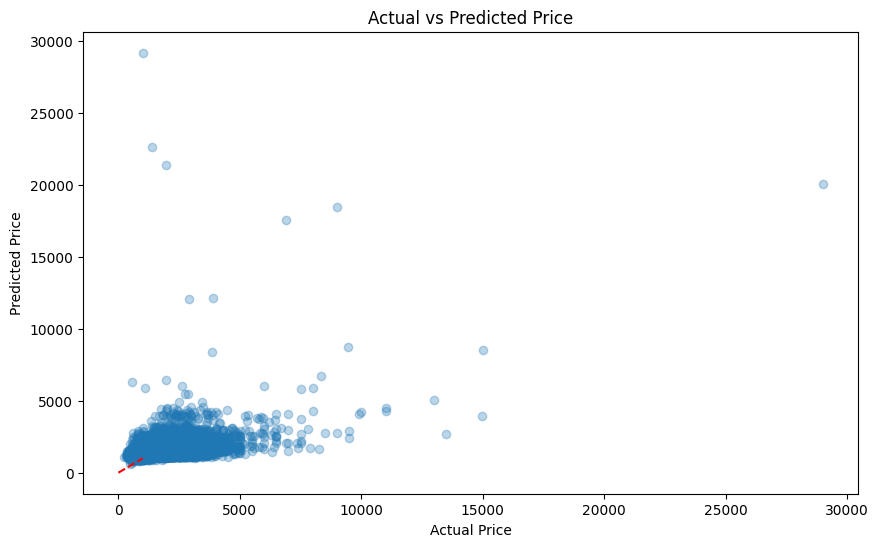

In [173]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Split the dataset into training and testing sets
X = df_clear[features]
y = df_clear['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models and parameter grids for hyperparameter tuning
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'SVR': SVR()
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.1, 1, 10, 100]},
    'DecisionTree': {'max_depth': [3, 5, 7, 10]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 10]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVR': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
}

# Train and evaluate models using GridSearchCV for hyperparameter tuning
best_models = {}
best_scores = {}

# Print the best models and their MSE scores
for name, model in models.items():
    print(f'Training {name}...')
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = -grid_search.best_score_

# Select the best model for prediction
print("\nBest Models and their MSE scores:")
for name, score in best_scores.items():
    print(f'{name}: MSE = {score}')

# Select the best model for prediction
best_model_name = min(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

print(f'\nBest Model: {best_model_name}')
y_pred = best_model.predict(X_test_scaled)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Visualize actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, 1000], [0, 1000], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()


### 6. Conclusion

In this project, I analyzed an apartment dataset, focusing on data cleaning, transformation, and visualization. By using K-Means clustering, I categorized the apartments into five distinct groups and proposed business strategies for each.

I learned the importance of thoroughly examining data to determine how to incorporate more comprehensive data sets. Handling unstructured text fields and transforming them into structured data is crucial for effective analysis. Visualizing the overall data helps in understanding its distribution and guides subsequent processing steps. Using maps to present data is challenging but valuable. Clustering proved to be a useful tool, allowing for targeted strategies based on the characteristics of each group.

This project provided me with valuable insights and a deeper understanding of data analysis and its practical applications.






